In [140]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [141]:
def read_data(file_path):
    # Open the file
    with open(file_path, 'r') as file:  # Use 'with' for automatic file closure

        # Split the text data into lines and remove extra whitespace
        lines = [line.strip() for line in file if line.strip()] 

        # Create a list to store data rows
        data = []

        # Process each line
        for line in lines:
            # Split the values in the line based on multiple spaces
            values = line.split()  
            
            # Convert values to floats
            values = [abs(float(val)) for val in values]

            # Add the row to the data list
            data.append(values)

    # Create a Pandas DataFrame
    column_names = [
        'absolute angle of inclination', 'angle of inclination', 'number of electrodes',
        'voltage magnitude', 'voltage frequency', 'electrode dimension',
        'x pitch', 'number of phases', 'grain mass density',
        'mesh size', 'gravity', 'phase shift', 'time step',
        'maximum classified radius', 'distance between dust generation and first electrode',
        'grain number density', 'yield'
    ]

    df = pd.DataFrame(data, columns=column_names)

    return df

def read_dataset_folder(folder_path):
    # Get a list of all files in the folder
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.txt')] 

    # Create an empty list to store DataFrames
    all_dataframes = []

    # Read each file and append its DataFrame to the list
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        df = read_data(file_path)
        all_dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    concatenated_df = pd.concat(all_dataframes, ignore_index=True)

    concatenated_df = concatenated_df.fillna(concatenated_df.mean())

    return concatenated_df

In [142]:
Folder_name = "Dataset"
data = read_dataset_folder(Folder_name)
data

,absolute angle of inclination,angle of inclination,number of electrodes,voltage magnitude,voltage frequency,electrode dimension,x pitch,number of phases,grain mass density,mesh size,gravity,phase shift,time step,maximum classified radius,distance between dust generation and first electrode,grain number density,yield
0,335.0,25.0,4.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014511,1.0,3.738749
1,335.0,25.0,6.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015185,1.0,2.602313
2,335.0,25.0,8.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015858,1.0,2.719417
3,335.0,25.0,10.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.016532,1.0,1.865867
4,335.0,25.0,4.0,500.0,5.0,4.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014011,1.0,6.512353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,50.0,50.0,4.0,2000.0,20.0,6.0,20.0,4.0,2000.0,0.001,9.0,90.0,0.005,0.00001,0.071505,1.0,9.115366
10238,50.0,50.0,6.0,2000.0,20.0,6.0,20.0,4.0,2000.0,0.001,9.0,90.0,0.005,0.00001,0.119175,1.0,2.328523
10239,50.0,50.0,8.0,2000.0,20.0,6.0,20.0,4.0,2000.0,0.001,9.0,90.0,0.005,0.00001,0.166846,1.0,0.453968
10240,50.0,50.0,10.0,2000.0,20.0,6.0,20.0,4.0,2000.0,0.001,9.0,90.0,0.005,0.00001,0.214516,1.0,0.141517


In [143]:
numeric_features = ['absolute angle of inclination', 'number of electrodes', 'electrode dimension',
                    'x pitch', 'distance between dust generation and first electrode', 'voltage magnitude',
                    'voltage frequency', 'grain mass density', 'gravity']

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = row[numeric_features].values.astype(np.float32)
        target = row['yield'].astype(np.float32)
        return features, target

In [144]:
dataset = CustomDataset(data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [145]:

class Net(nn.Module):
    def __init__(self, hidden_layer_size, input_size = len(numeric_features), dropout_prob=0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [146]:
epochs = 20
train_losses = []
val_losses = []
batch_size = 8
hidden_layer_size = 32

In [147]:
def rmse_loss(outputs, targets):
    return torch.sqrt(F.mse_loss(outputs, targets.unsqueeze(1)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


model = Net(hidden_layer_size).to(device)
model = model.float()
criterion = rmse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset.to_device = to_device
val_dataset.to_device = to_device

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using cuda device


In [148]:
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}', end=" ")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Test Loss: {val_loss:.6f}')

Epoch 1, Train Loss: 6.670083 Test Loss: 5.570464
Epoch 2, Train Loss: 5.623596 Test Loss: 5.329835
Epoch 3, Train Loss: 5.358334 Test Loss: 5.377835
Epoch 4, Train Loss: 5.205268 Test Loss: 5.687937
Epoch 5, Train Loss: 5.112995 Test Loss: 5.087356
Epoch 6, Train Loss: 4.948205 Test Loss: 5.317622
Epoch 7, Train Loss: 4.800379 Test Loss: 4.662181
Epoch 8, Train Loss: 4.679655 Test Loss: 4.619746
Epoch 9, Train Loss: 4.624512 Test Loss: 4.383606
Epoch 10, Train Loss: 4.472820 Test Loss: 4.252876
Epoch 11, Train Loss: 4.421203 Test Loss: 4.681173
Epoch 12, Train Loss: 4.376368 Test Loss: 4.964866
Epoch 13, Train Loss: 4.323774 Test Loss: 4.127784
Epoch 14, Train Loss: 4.251522 Test Loss: 4.662105
Epoch 15, Train Loss: 4.196421 Test Loss: 4.301205
Epoch 16, Train Loss: 4.134698 Test Loss: 3.990057
Epoch 17, Train Loss: 4.061324 Test Loss: 4.018607
Epoch 18, Train Loss: 4.039065 Test Loss: 4.156826
Epoch 19, Train Loss: 4.028270 Test Loss: 4.154880
Epoch 20, Train Loss: 3.952351 Test Loss

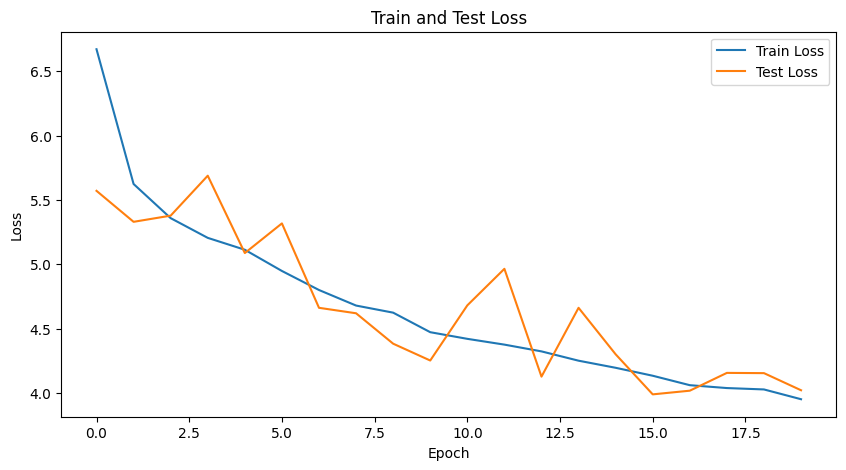

In [149]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

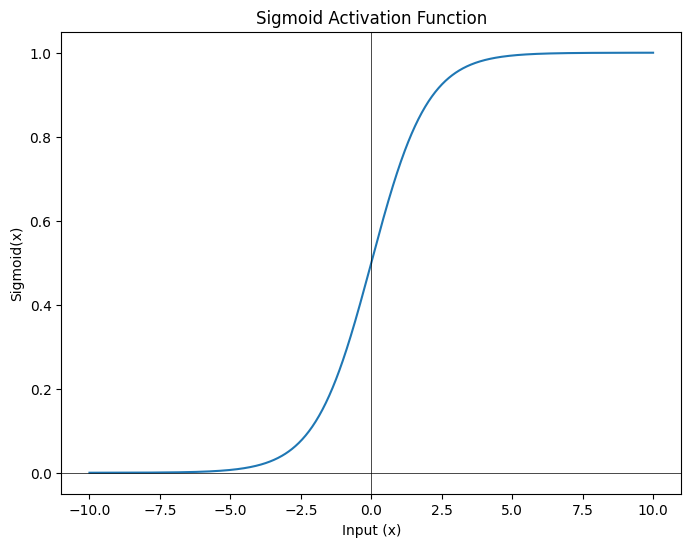

In [150]:
import torch
import matplotlib.pyplot as plt

# Create a tensor of input values
x = torch.linspace(-10, 10, 1000)

# Apply the sigmoid function
sigmoid = torch.nn.Sigmoid()
y = sigmoid(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y.numpy(), label="Sigmoid(x)")
plt.xlabel("Input (x)")
plt.ylabel("Sigmoid(x)")
plt.title("Sigmoid Activation Function")
#plt.grid(True)
#plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()
